In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import re
from PIL import Image
import requests
import random
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os

In [ ]:
from google.colab import files
files.upload()

In [5]:
mkdir /root/.kaggle

In [6]:
mv kaggle.json /root/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

In [9]:
import zipfile

with zipfile.ZipFile('book-recommendation-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [10]:
os.listdir('.')

['.config',
 '~',
 'Ratings.csv',
 'Users.csv',
 'Books.csv',
 'book-recommendation-dataset.zip',
 'DeepRec.png',
 'recsys_taxonomy2.png',
 'classicRec.png',
 'sample_data']

In [11]:
books = pd.read_csv('Books.csv', encoding='latin-1')
users = pd.read_csv('Users.csv', encoding='latin-1')
ratings = pd.read_csv('Ratings.csv', encoding='latin-1')

<ipython-input-11-00dd461ec22e>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv', encoding='latin-1')


In [12]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [13]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [14]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [15]:
# data shape
print("Books shape: ", books.shape)
print("Users shape: ", users.shape)
print("Ratings shape: ", ratings.shape)

Books shape:  (271360, 8)
Users shape:  (278858, 3)
Ratings shape:  (1149780, 3)


In [16]:
# null value info
print("Null value info in Books:\n", books.isnull().sum())
print("\nNull value info in Users:\n", users.isnull().sum())
print("\nNull value info in Ratings:\n", ratings.isnull().sum())

Null value info in Books:
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Null value info in Users:
 User-ID          0
Location         0
Age         110762
dtype: int64

Null value info in Ratings:
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [17]:
# duplicate values info
print("Duplicate values in Books:\n", books.duplicated().sum())
print("\nDuplicate values in Users:\n", users.duplicated().sum())
print("\nDuplicate values in Ratings:\n", ratings.duplicated().sum())

Duplicate values in Books:
 0

Duplicate values in Users:
 0

Duplicate values in Ratings:
 0


### Preprocessing

In [18]:
books_df = books.merge(ratings,on='ISBN')
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [19]:
books_with_ratings = books_df.copy()

In [20]:
# removing any non-alphanumeric characters (excluding spaces) from the book titles
books_with_ratings['Book-Title'] = books_with_ratings['Book-Title'].apply(lambda x: re.sub("[\W]+"," ",x).strip())

In [21]:
books_with_ratings.shape

(1031136, 10)

Popularity Based Recommender System

In [22]:
# count number of ratings on each book
ratings_count_df = books_with_ratings.groupby('Book-Title').count()['Book-Rating'].reset_index()
ratings_count_df.rename(columns={'Book-Rating':'Number_of_votes'},inplace=True)
ratings_count_df.head()

,Book-Title,Number_of_votes
0,006781 Bk 1 Gags De Boule Et Bil,1
1,007 El Mundo Nunca Es Suficiente,1
2,01 01 00 A Novel of the Millennium,10
3,01 01 00 The Novel of the Millennium,22
4,03 NODDY AND HIS CAR,1


In [23]:
# average rating of each book
avg_rating_df = books_with_ratings.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_rating_df.rename(columns={'Book-Rating':'Average_rating'},inplace=True)
avg_rating_df.sample(5)

,Book-Title,Average_rating
163164,Southern Living 1996 Annual Recipes Serial,5.000000
224804,Valentine Baby That S My Baby Harlequin Specia...,0.000000
75813,Goofy Joins the Circus,10.000000
84393,Honest Doubt,1.888889
163322,Spangle,3.500000


In [24]:
popular_books_df = ratings_count_df.merge(avg_rating_df,on='Book-Title')
popular_books_df.sample(5)

,Book-Title,Number_of_votes,Average_rating
214283,The knowledge and the power Reflections on the...,1,0.0
181245,The Constructor,1,0.0
202651,The Reason Why,1,0.0
174606,The Art of Rubber Stamping,1,8.0
149056,Right Cowboy S Bed Caught With A Cowboy Harleq...,2,2.5


In [25]:
popular_books_df.describe()

,Number_of_votes,Average_rating
count,239062.000000,239062.000000
mean,4.313258,2.888423
std,16.934733,3.266669
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,2.000000
75%,3.000000,5.000000
max,2502.000000,10.000000


Considering only those books with number of ratings >= 250

In [26]:
popular_books_df = popular_books_df[popular_books_df['Number_of_votes']>=250]

In [27]:
popular_books_df.shape

(191, 3)

In [28]:
popular_books_df.isnull().sum()

,0
Book-Title,0
Number_of_votes,0
Average_rating,0


In [29]:
popular_books_df.duplicated().sum()

0

In [30]:
popular_books_df.describe()

,Number_of_votes,Average_rating
count,191.000000,191.000000
mean,401.497382,3.445699
std,215.539076,0.710347
min,252.000000,1.019584
25%,280.000000,2.999766
50%,336.000000,3.361257
75%,468.000000,3.807571
max,2502.000000,5.852804


### Computing Weightage Average for Individual book's average rating

In [31]:
# function to calculate weighted average rating
def weighted_avg_rating(x):
    v = x['Number_of_votes']
    R = x['Average_rating']

    return ((v*R) + (m*C)) / (v+m)
m = popular_books_df['Number_of_votes'].quantile(0.90)
C = popular_books_df['Average_rating'].mean()

In [32]:
# calculating the weighted average rating for popular books
popular_books_df['Popularity'] = popular_books_df.apply(weighted_avg_rating, axis=1)

# sorting popular books based on popularity
popular_books_df = popular_books_df.sort_values(by='Popularity', ascending=False)

In [33]:
popular_books_df.describe()

,Number_of_votes,Average_rating,Popularity
count,191.000000,191.000000,191.000000
mean,401.497382,3.445699,3.448186
std,215.539076,0.710347,0.310358
min,252.000000,1.019584,1.471670
25%,280.000000,2.999766,3.264538
50%,336.000000,3.361257,3.412201
75%,468.000000,3.807571,3.584852
max,2502.000000,5.852804,4.474911


In [34]:
df_list = popular_books_df.merge(books_with_ratings, on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Number_of_votes','Average_rating','Popularity']].head(10)

print('At 4:',df_list['Book-Title'].tolist()[4])
print('At 6:',df_list['Book-Title'].tolist()[6])

At 4: Harry Potter and the Sorcerer s Stone Book 1
At 6: Harry Potter and the Sorcerer s Stone Harry Potter Paperback


In [35]:
popular_books_df.head(8)

,Book-Title,Number_of_votes,Average_rating,Popularity
79765,Harry Potter and the Prisoner of Azkaban Book 3,428,5.852804,4.474911
79753,Harry Potter and the Goblet of Fire Book 4,387,5.824289,4.404569
79746,Harry Potter and the Chamber of Secrets Book 2,556,5.183453,4.301493
79757,Harry Potter and the Order of the Phoenix Book 5,347,5.501441,4.221072
79773,Harry Potter and the Sorcerer s Stone Book 1,278,5.737410,4.194343
182131,The Da Vinci Code,898,4.642539,4.176333
79778,Harry Potter and the Sorcerer s Stone Harry Po...,575,4.895652,4.171939
194783,The Lovely Bones A Novel,1295,4.468726,4.154917


In [36]:
def Top_popular_books(n):
    top_n_books = popular_books_df.reset_index(drop=True).head(n)

    return top_n_books

In [37]:
Top_popular_books(10)

,Book-Title,Number_of_votes,Average_rating,Popularity
0,Harry Potter and the Prisoner of Azkaban Book 3,428,5.852804,4.474911
1,Harry Potter and the Goblet of Fire Book 4,387,5.824289,4.404569
2,Harry Potter and the Chamber of Secrets Book 2,556,5.183453,4.301493
3,Harry Potter and the Order of the Phoenix Book 5,347,5.501441,4.221072
4,Harry Potter and the Sorcerer s Stone Book 1,278,5.737410,4.194343
5,The Da Vinci Code,898,4.642539,4.176333
6,Harry Potter and the Sorcerer s Stone Harry Po...,575,4.895652,4.171939
7,The Lovely Bones A Novel,1295,4.468726,4.154917
8,To Kill a Mockingbird,510,4.700000,4.036367
9,The Fellowship of the Ring The Lord of the Rin...,368,4.948370,4.033354


In [38]:
def show_top_books(n):

    top_n = Top_popular_books(n)
    fig,ax = plt.subplots(1,5,figsize=(17,5))
    fig.suptitle("MOST POPULAR BOOKS",fontsize = 40,color = "deepskyblue")
    for i in range(len(top_n["Book-Title"].tolist())):
        url=books_with_ratings.loc[books_with_ratings["Book-Title"]==top_n["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
        img=Image.open(requests.get(url,stream=True).raw)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title("RATING: {} ".format(round(books_with_ratings[books_with_ratings["Book-Title"]==top_ten["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=10)
        fig.show()

In [39]:
url = books_with_ratings['Image-URL-L'][8]
from io import BytesIO
response = requests.get(url)

if response.status_code == 200:
    img = Image.open(BytesIO(response.content))
    img.show()
else:
    print(f"Failed to retrieve image. Status code: {response.status_code}")

Failed to retrieve image. Status code: 403


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7c36b47d2c50>

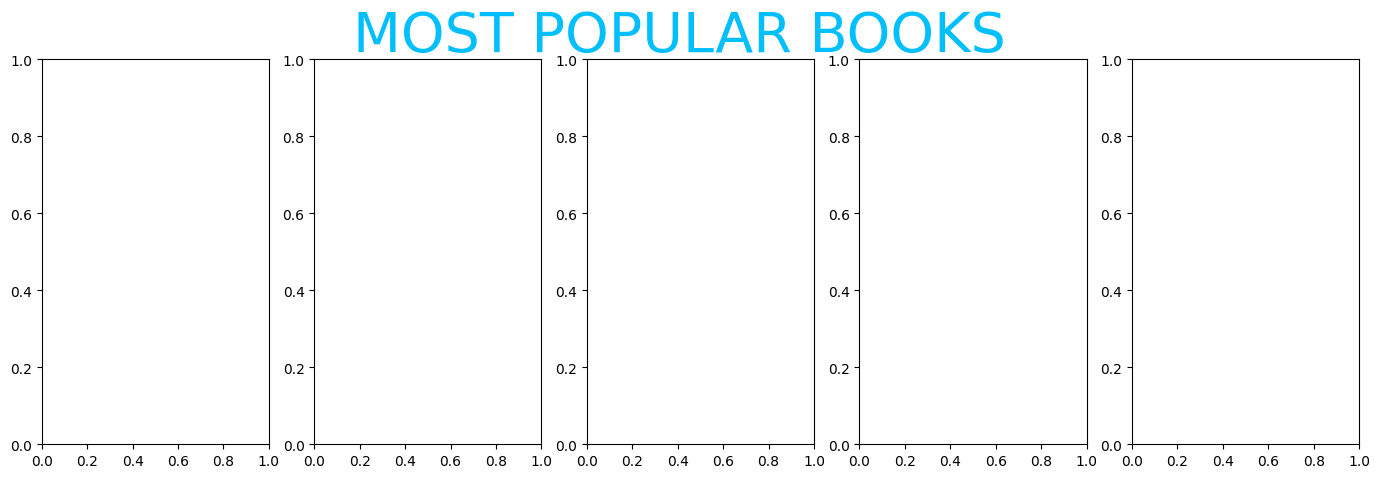

In [40]:
show_top_books(5)

### Collaborative Filtering Based Recommender System

In [41]:
# no. of books rated by users
books_with_ratings.groupby('User-ID').count()['Book-Rating']


,Book-Rating
User-ID,
2,1
8,17
9,3
10,1
12,1
...,...
278846,1
278849,4
278851,23


In [42]:
new_df=books_with_ratings[books_with_ratings['User-ID'].map(books_with_ratings['User-ID'].value_counts()) > 200]
new_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
6,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,85526,0
7,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,96054,0
10,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,177458,0
21,0374157065,Flu The Story of the Great Influenza Pandemic ...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,110912,10
...,...,...,...,...,...,...,...,...,...,...
1031124,0231128444,Slow Food The Case For Taste,Carlo Petrini,2003,Columbia University Press,http://images.amazon.com/images/P/0231128444.0...,http://images.amazon.com/images/P/0231128444.0...,http://images.amazon.com/images/P/0231128444.0...,275970,0
1031125,0520242335,Strong Democracy Participatory Politics for a ...,Benjamin R. Barber,2004,University of California Press,http://images.amazon.com/images/P/0520242335.0...,http://images.amazon.com/images/P/0520242335.0...,http://images.amazon.com/images/P/0520242335.0...,275970,0
1031126,0762412119,Burpee Gardening Cyclopedia A Concise Up to Da...,Allan Armitage,2002,Running Press Book Publishers,http://images.amazon.com/images/P/0762412119.0...,http://images.amazon.com/images/P/0762412119.0...,http://images.amazon.com/images/P/0762412119.0...,275970,0
1031127,1582380805,Tropical Rainforests 230 Species in Full Color...,"Allen M., Ph.D. Young",2001,Golden Guides from St. Martin's Press,http://images.amazon.com/images/P/1582380805.0...,http://images.amazon.com/images/P/1582380805.0...,http://images.amazon.com/images/P/1582380805.0...,275970,0


In [43]:
# filtering users who voted more than 200 times
x = books_with_ratings.groupby('User-ID').count()['Book-Rating'] > 200
relevant_users = x[x].index
relevant_users

Index([   254,   2276,   2766,   2977,   3363,   4017,   4385,   6251,   6323,
         6543,
       ...
       271705, 273979, 274004, 274061, 274301, 274308, 275970, 277427, 277639,
       278418],
      dtype='int64', name='User-ID', length=811)

In [44]:
relevant_books = books_with_ratings[books_with_ratings['User-ID'].isin(relevant_users)]
relevant_books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
6,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,85526,0
7,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,96054,0
10,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,177458,0
21,0374157065,Flu The Story of the Great Influenza Pandemic ...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,110912,10


In [45]:
# filtering books with atleast 50 votes
filtered_books = relevant_books.groupby('Book-Title').count()['Book-Rating'] >= 50
filtered_books = filtered_books[filtered_books].index
type(filtered_books)

pandas.core.indexes.base.Index

In [46]:
final_df = relevant_books[relevant_books['Book-Title'].isin(filtered_books)]
final_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
31,0399135782,The Kitchen God s Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,11676,9
33,0399135782,The Kitchen God s Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,36836,0
34,0399135782,The Kitchen God s Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,46398,9
38,0399135782,The Kitchen God s Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,113270,0
39,0399135782,The Kitchen God s Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,113519,0
...,...,...,...,...,...,...,...,...,...,...
1028414,1878702831,Echoes,Nancy Morse,1992,Meteor Publishing Corporation,http://images.amazon.com/images/P/1878702831.0...,http://images.amazon.com/images/P/1878702831.0...,http://images.amazon.com/images/P/1878702831.0...,238781,0
1028600,0394429869,I Know Why the Caged Bird Sings,Maya Angelou,1996,Random House,http://images.amazon.com/images/P/0394429869.0...,http://images.amazon.com/images/P/0394429869.0...,http://images.amazon.com/images/P/0394429869.0...,239594,8
1028602,0449001164,The Promise,CHAIM POTOK,1997,Ballantine Books,http://images.amazon.com/images/P/0449001164.0...,http://images.amazon.com/images/P/0449001164.0...,http://images.amazon.com/images/P/0449001164.0...,239594,7
1028815,0743527631,The Pillars of the Earth,Ken Follett,2002,Encore,http://images.amazon.com/images/P/0743527631.0...,http://images.amazon.com/images/P/0743527631.0...,http://images.amazon.com/images/P/0743527631.0...,240144,0


In [47]:
final_df.duplicated().sum()

0

In [48]:
pt = final_df.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating' )

In [49]:
pt.fillna(0,inplace=True)
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wuthering Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
# similarity scores of books
similarity_scores = cosine_similarity(pt)
similarity_scores

array([[1.        , 0.10255025, 0.01220856, ..., 0.01769644, 0.15288195,
        0.07347567],
       [0.10255025, 1.        , 0.2364573 , ..., 0.19309722, 0.07349947,
        0.16773875],
       [0.01220856, 0.2364573 , 1.        , ..., 0.16565383, 0.04499872,
        0.04938579],
       ...,
       [0.01769644, 0.19309722, 0.16565383, ..., 1.        , 0.05149434,
        0.19430288],
       [0.15288195, 0.07349947, 0.04499872, ..., 0.05149434, 1.        ,
        0.06993609],
       [0.07347567, 0.16773875, 0.04938579, ..., 0.19430288, 0.06993609,
        1.        ]])

In [52]:
print('similarity scores shape: ',similarity_scores.shape)
similarity_scores[0].shape

similarity scores shape:  (709, 709)


(709,)

In [53]:
def recommend(book_name):
    # index fetch
    if book_name in pt.index:
        index = np.where(pt.index == book_name)[0][0]

        similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:6]

        data = []
        for i in similar_items:
            item = []
            temp_df = books_with_ratings[books_with_ratings['Book-Title'] == pt.index[i[0]]]
            item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
            item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
            #item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))

            data.append(item)

        return data

    else:
        print('Book not found')


In [54]:
recommend('A Bend in the Road')

[['A Walk to Remember', 'Nicholas Sparks'],
 ['The Last Time They Met A Novel', 'Anita Shreve'],
 ['Sea Glass A Novel', 'Anita Shreve'],
 ['Angels', 'Marian Keyes'],
 ['Family Album', 'Danielle Steel']]

In [65]:
recommend('1984')

[['Animal Farm', 'George Orwell'],
 ['The Handmaid s Tale', 'Margaret Atwood'],
 ['Brave New World', 'Aldous Huxley'],
 ['The Vampire Lestat Vampire Chronicles Book II', 'ANNE RICE'],
 ['Fahrenheit 451', 'Ray Bradbury']]

In [ ]:
books_with_ratings = books_with_ratings.drop(columns=['Image-URL-S','Image-URL-M', 'Image-URL-L'])

### Pickle

In [66]:
# pickle files
pickle.dump(popular_books_df,open('popular.pkl','wb'))
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(books_with_ratings,open('books_with_ratings.pkl','wb'))
pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))

In [65]:
from google.colab import files

# Download the pickle files to your local system
files.download('/content/popular.pkl')
files.download('/content/pt.pkl')
files.download('/content/books_with_ratings.pkl')
files.download('/content/similarity_scores.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>